In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
import scipy.stats
import time
from useful_funcs import PAUSflux_to_ABmag
import h5py
import matplotlib.colors
import os
from SAVEFIG import main as custom_SAVEFIG

latex_textwidth = 455.24#pt

def fixed_aspect_ratio(ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = plt.gca().axes.get_xlim(),plt.gca().axes.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    plt.gca().set_aspect(ratio*(xrange/yrange), adjustable='box')

#matplotlib.rcParams['agg.path.chunksize'] = 10000

In [3]:
from astropy.cosmology import Planck15 as cosmo

cosmo = cosmo.clone(name='Planck15 H0 = 100', H0=100) #setting H0 = 100 km/s/MPc, h = 1


In [4]:
data = pd.read_pickle("../../Data/Object_zs_zp_181203_130401.pkl.gz")


lcCoreFilename = "Gonzalez13.PAU.MillGas.field1.core.0.hdf5"
lcPhotomFilename = "Gonzalez13.PAU.MillGas.field1.photometry.0.hdf5"

if os.environ['NAME'] == 'DESKTOP-RB5C8OC': 
    file_path = '/mnt/e/L4ProjectLocal/LightConeData/'
elif os.environ['NAME'] == 'LaNaranjaDos':
    file_path = '/mnt/c/Users/Andrew/L4ProjectLocal/Light Cone Data/'
else: raise Exception('Device not configured for hdf5 data load')

LC_DATA_CORE = h5py.File(file_path+lcCoreFilename, "r")
LC_DATA_PHOTOM = h5py.File(file_path+lcPhotomFilename, "r")

In [5]:
data.shape

(47233, 176)

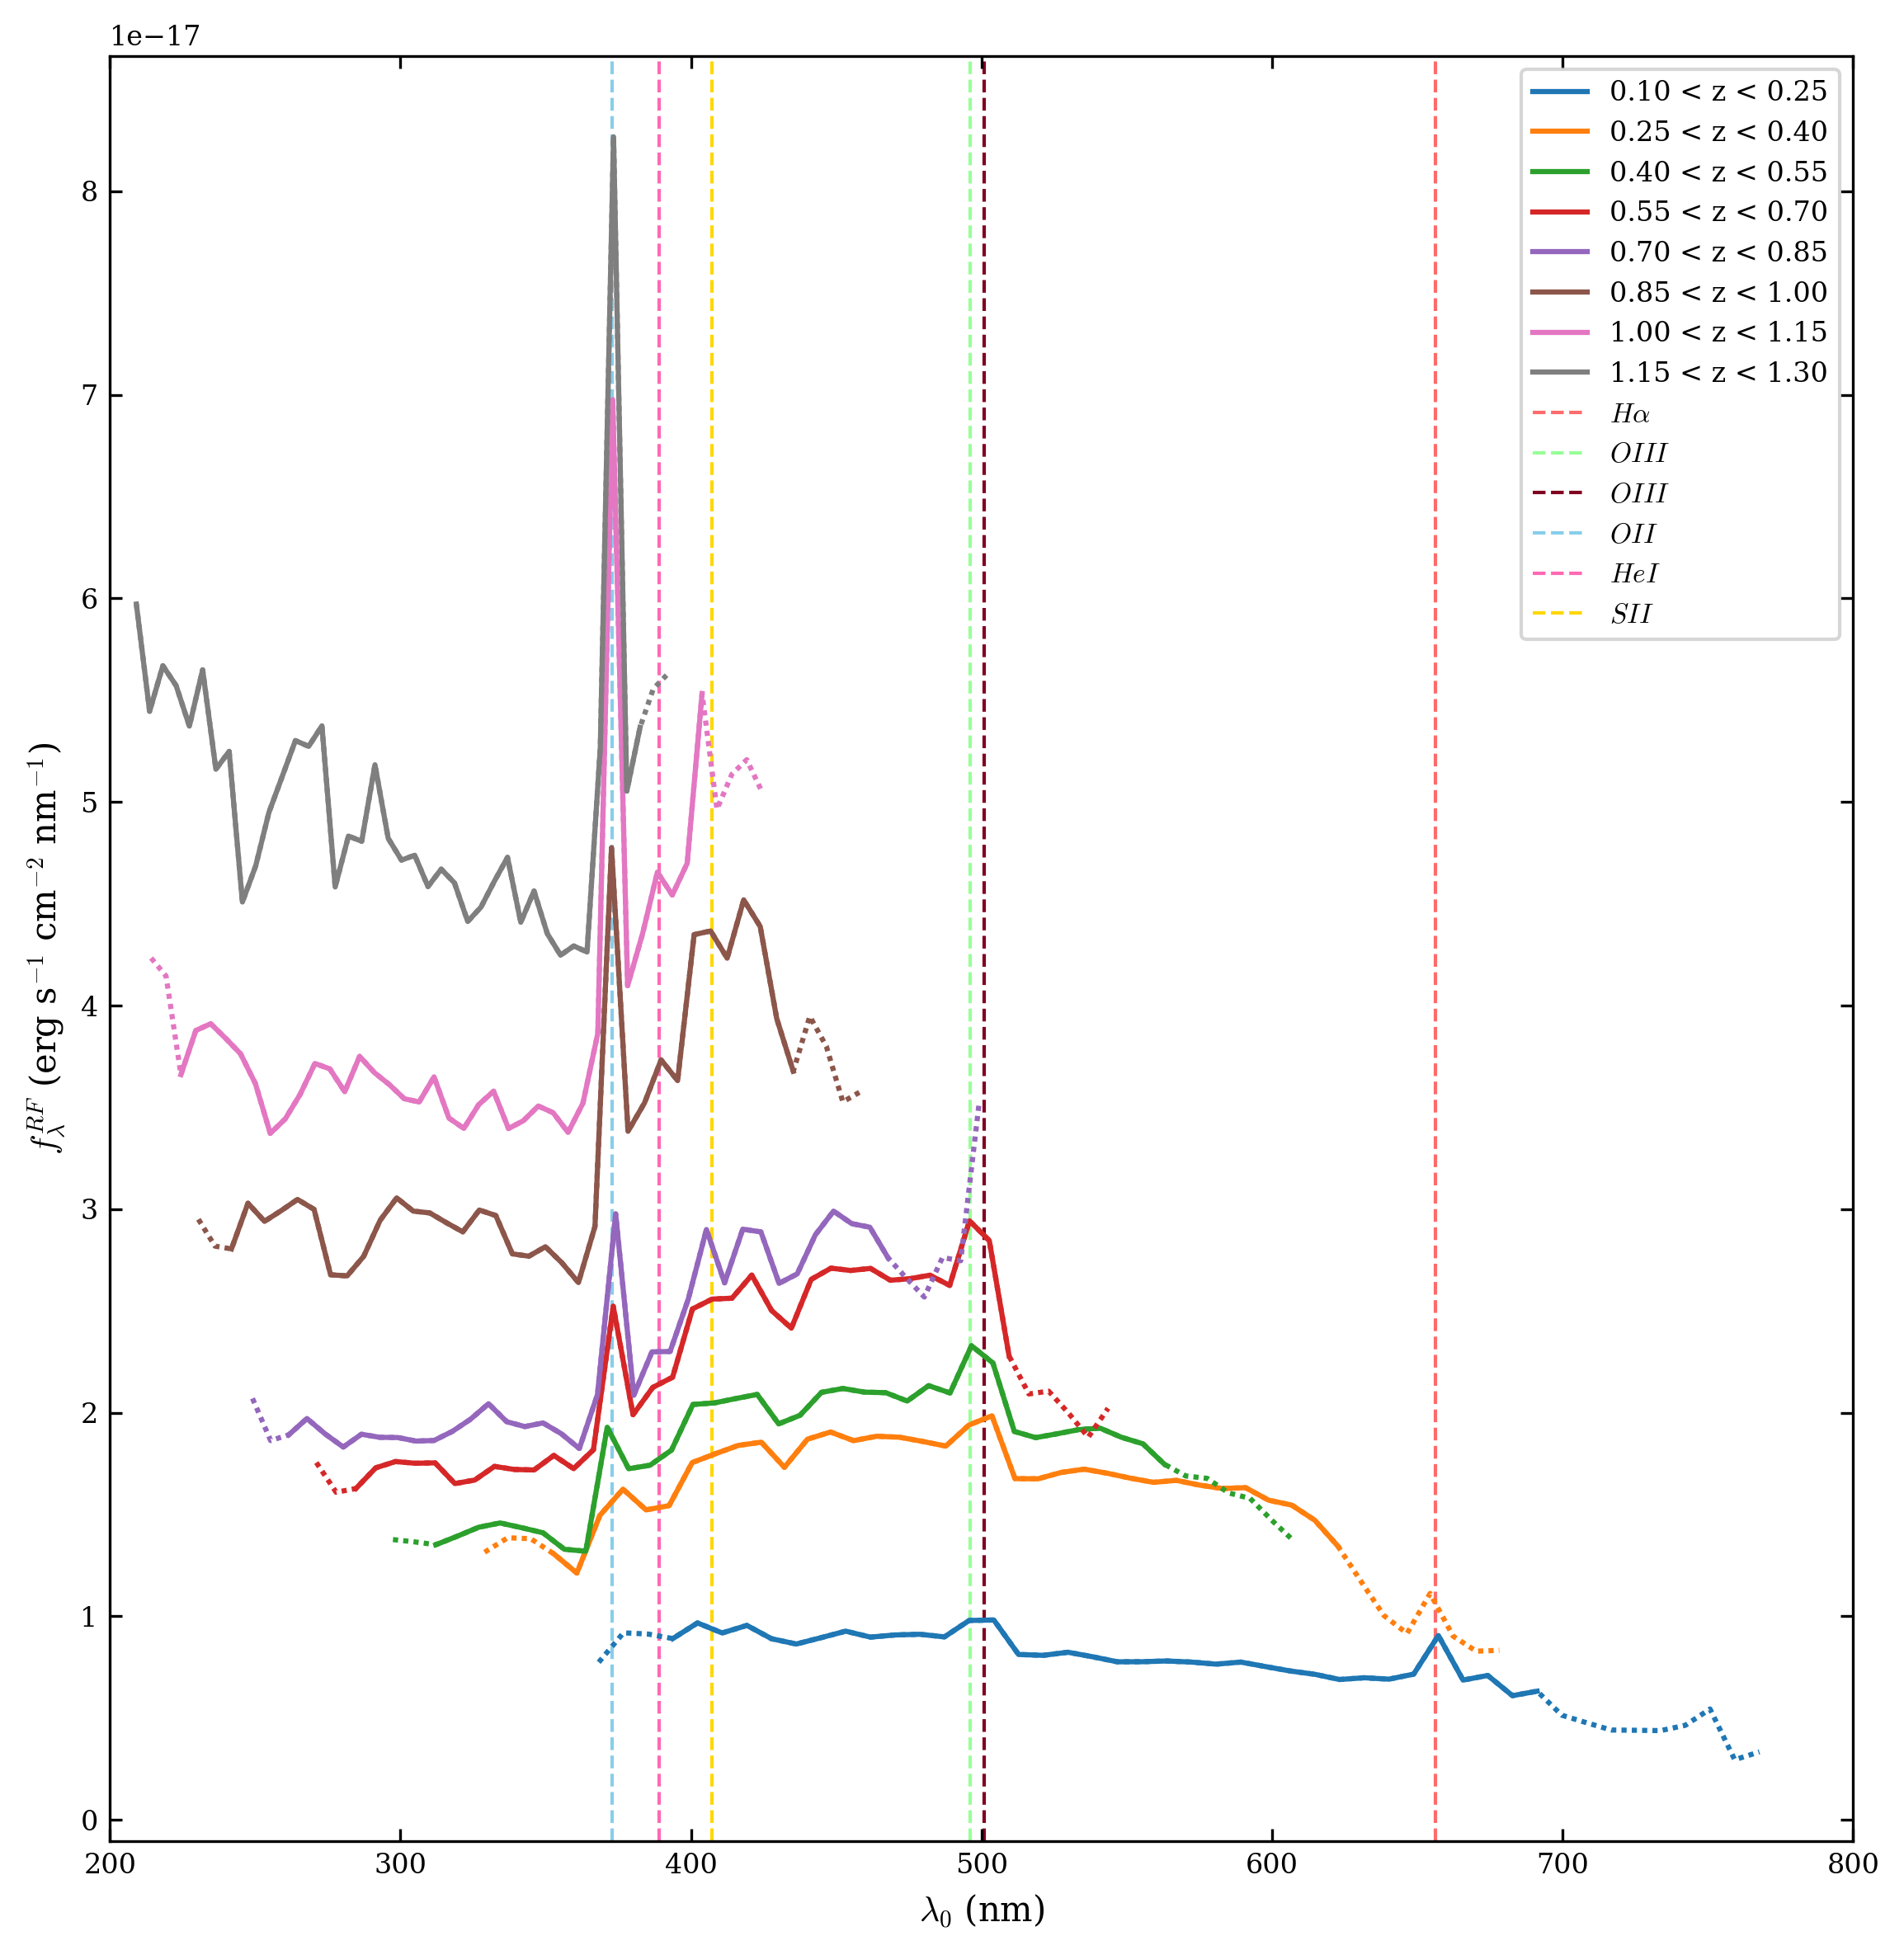

In [6]:
mask = data['conf'].astype('str').str.match('^[34]\.[0-9]$') | data['conf'].astype('str').str.match('^[29]\.5$') 
data_sample = data.loc[(data['n_bands']>=30)]# & mask & (data['zspec']!=0)]

lum_dists_1d = cosmo.luminosity_distance(data_sample['zb']).value
# calculate luminosity distance for all objects

luminosity_distances = np.repeat(lum_dists_1d[:,None],40,axis=1)
z_photos = data_sample['zb']


FWHM = 13 # nm
c = 299792458e9 # nm s^-1
cgs_factor = 10**(-(26+48.6)/2.5)
# defining FWHM of filter, PAUS flux -> cgs unit conversion factor, speed of light


bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
# temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
# for ind,i in enumerate(temp_bins[:-1]):
#     bins.append([temp_bins[ind],temp_bins[ind+1]]) 

bins = np.arange(bin_range[0],bin_range[1]+bin_increment, bin_increment)
# setting up redshift bin intervals

factor = 1/8.5 * latex_textwidth/72

fig = plt.figure(figsize=(8,8),dpi=300)
# ax1 = plt.subplot(121)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)
# converting waveegnths to restframe

all_means = []
percent_data = []
percent_data_x = []

bandwidtharray = np.linspace(8.5,4,len(bins))
# width of bins


for ind,z_bin in enumerate(bins[:-1]):

    truth_table = (z_photos >= bins[ind]) & (z_photos <= bins[ind+1])
    n_objects = truth_table.sum()
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    # selecting relevant data based on redshift range
    
    z_samp = np.repeat(z_photos[truth_table],40)
    # selecting sample of zb
    
    lum_dist_sample = luminosity_distances[truth_table].flatten()
    # selecting only relevant LDs
    
    band_width = bandwidtharray[ind]
    band_bins = np.arange(np.nanmin(lamb_sample),np.nanmax(lamb_sample)+band_width,band_width)
    # calculating wl bins
          
    N_objects = band_obsframe[truth_table].shape[0]
    digitized = np.digitize(lamb_sample,band_bins)
    # calculating where objects fall in wl bins
      
    # binned_means = [np.nanmedian(flux_sample[digitized == i]/FWHM*(1+z_samp[digitized == i])) for i in range(1,len(band_bins))]
    # ^ what has been used so far
    
    binned_means = [np.nanmedian(flux_sample[digitized == i]*z_samp[digitized == i]*cgs_factor*c/(lamb_sample[digitized==i])**2) for i in range(1,len(band_bins))]
    # f_RF = f/(1+z) * cgs_factor * c/lambda^2
    
    binobject_count = np.bincount(digitized)
    percent_data.append(binobject_count/n_objects) 
    eighty_percent_mask = binobject_count/n_objects >= 0.75
    eighty_percent_mask = eighty_percent_mask[1:-1]    
    
    all_means.append(binned_means) #flux(in AB mags)/band wl
    
    
    line = plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
             zorder=10,linewidth=1.5,linestyle='--', dashes = (1,1)) #flux(in AB mags)/500 band wl
    # plot median of redshift bin of all wl bins as dashed line
    
    plottingbins = (band_bins[1:]+band_bins[:-1])/2
    percent_data_x.append(plottingbins)
    masked_data_x = np.ma.masked_where(~eighty_percent_mask,plottingbins)
    masked_data_y = np.ma.masked_where(~eighty_percent_mask,binned_means)
    plt.plot(masked_data_x,masked_data_y,\
             label="{:.02f} < z < {:.02f}".format(bins[ind],bins[ind+1]),\
             zorder=10,linewidth=1.5,linestyle='-', color=line[0].get_color())                                 
        



emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]
colours = ['#ff6b6b','#98ff98','#800020','skyblue','hotpink','gold','black','white']
for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],color=colours[i],linestyle='--',zorder=1,label=line[1])
# plotting emission lines with set colours


plt.xlabel(r'$\lambda_0$ (nm)')
plt.ylabel(r'$f^{RF}_{\lambda}$ (erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$)')
# plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1),ncol=2,frameon=False)
fixed_aspect_ratio(1)
# custom_SAVEFIG(filetag='SED_LD')

# plt.yscale('log')
# plt.ylim([0,2.5e6])
plt.xlim([200,800])
# plt.show()

# fig.subplots_adjust(wspace=0.25)
# fig.subplots_adjust(bottom=0.3)
# ax1.yaxis.labelpad, ax2.yaxis.labelpad = 1,1

plt.legend()
plt.tight_layout()
# custom_SAVEFIG(filetag='SED')
plt.show()



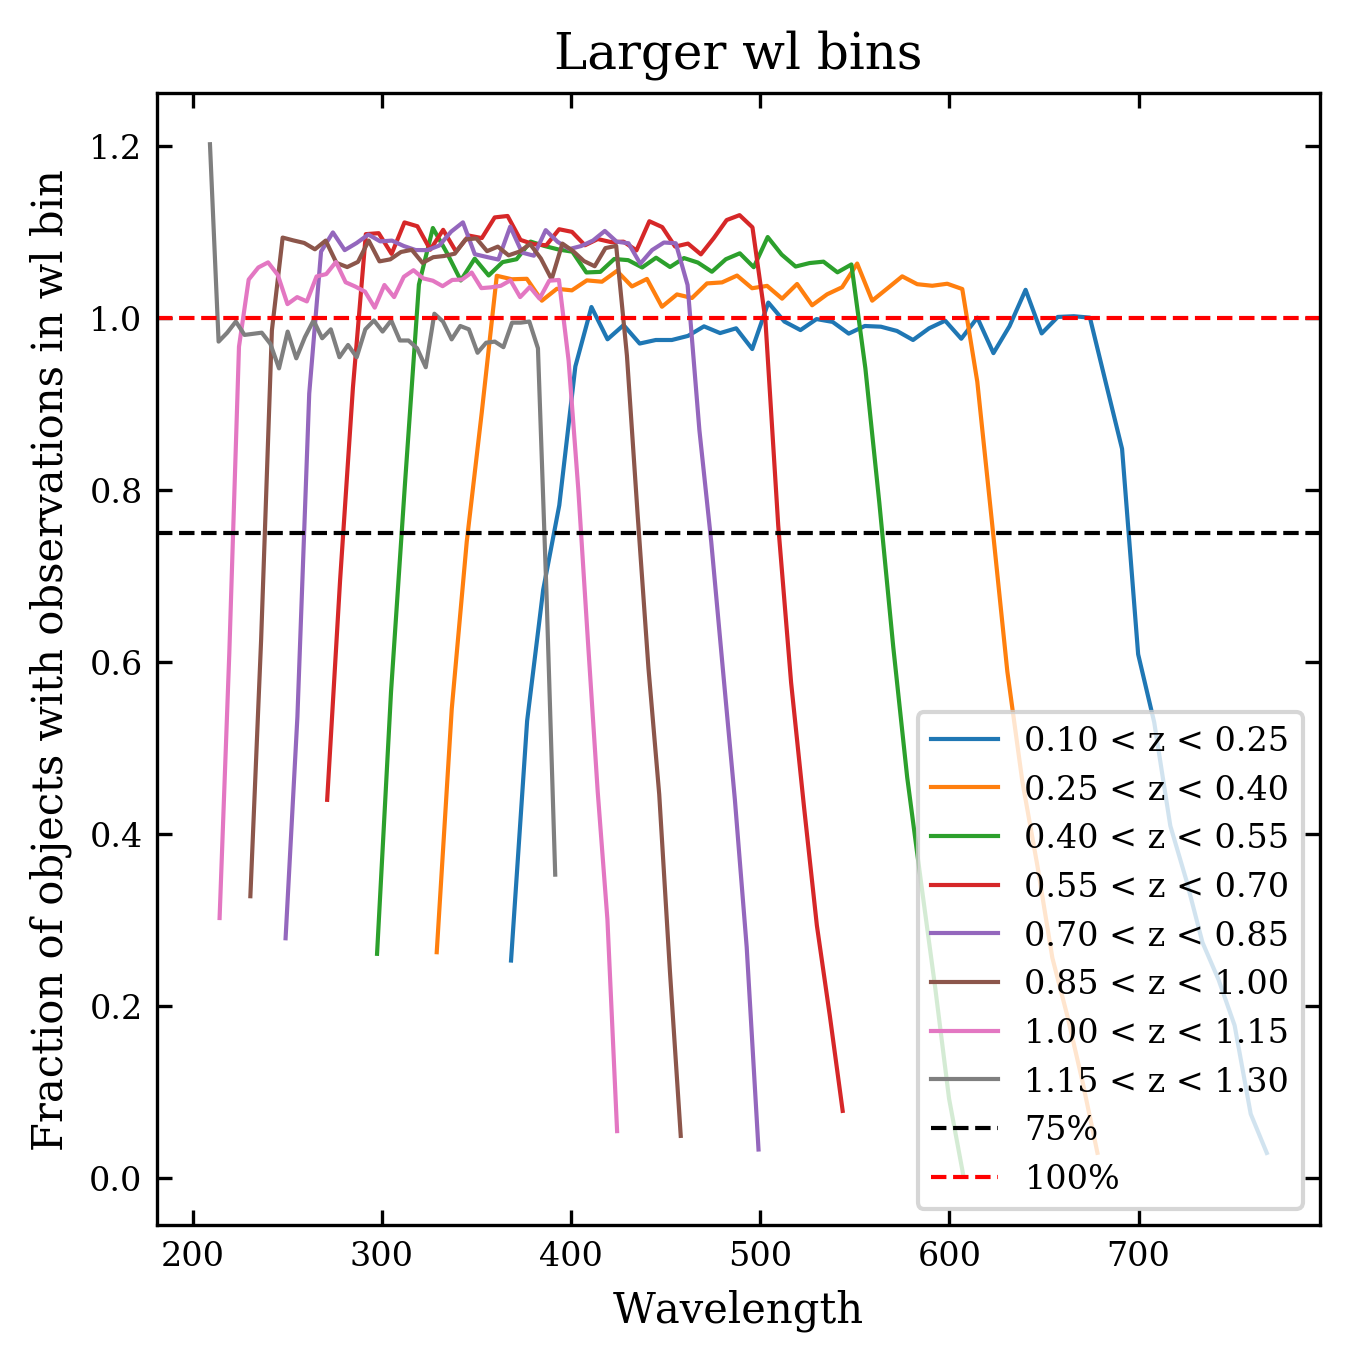

In [7]:
plt.figure(figsize=(5,5),dpi=300)

for ind,i in enumerate(percent_data):
    plt.plot(percent_data_x[ind],percent_data[ind][1:-1],label="{:.02f} < z < {:.02f}".format(bins[ind],bins[ind+1]))

plt.axhline(0.75,color='k',linestyle='--',label='75%')
plt.axhline(1,color='red',linestyle='--',label='100%')
plt.ylabel('Fraction of objects with observations in wl bin')
plt.xlabel('Wavelength')
plt.legend(loc='lower right')
plt.title('Larger wl bins')
plt.show()

/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:4197: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:2551: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()
/home/andrew/.local/lib/python3.6/site-packages/matplotlib/axes/_base.py:838: UserWarning: aspect is not supported for Axes with xscale=linear, yscale=log
  self.apply_aspect()


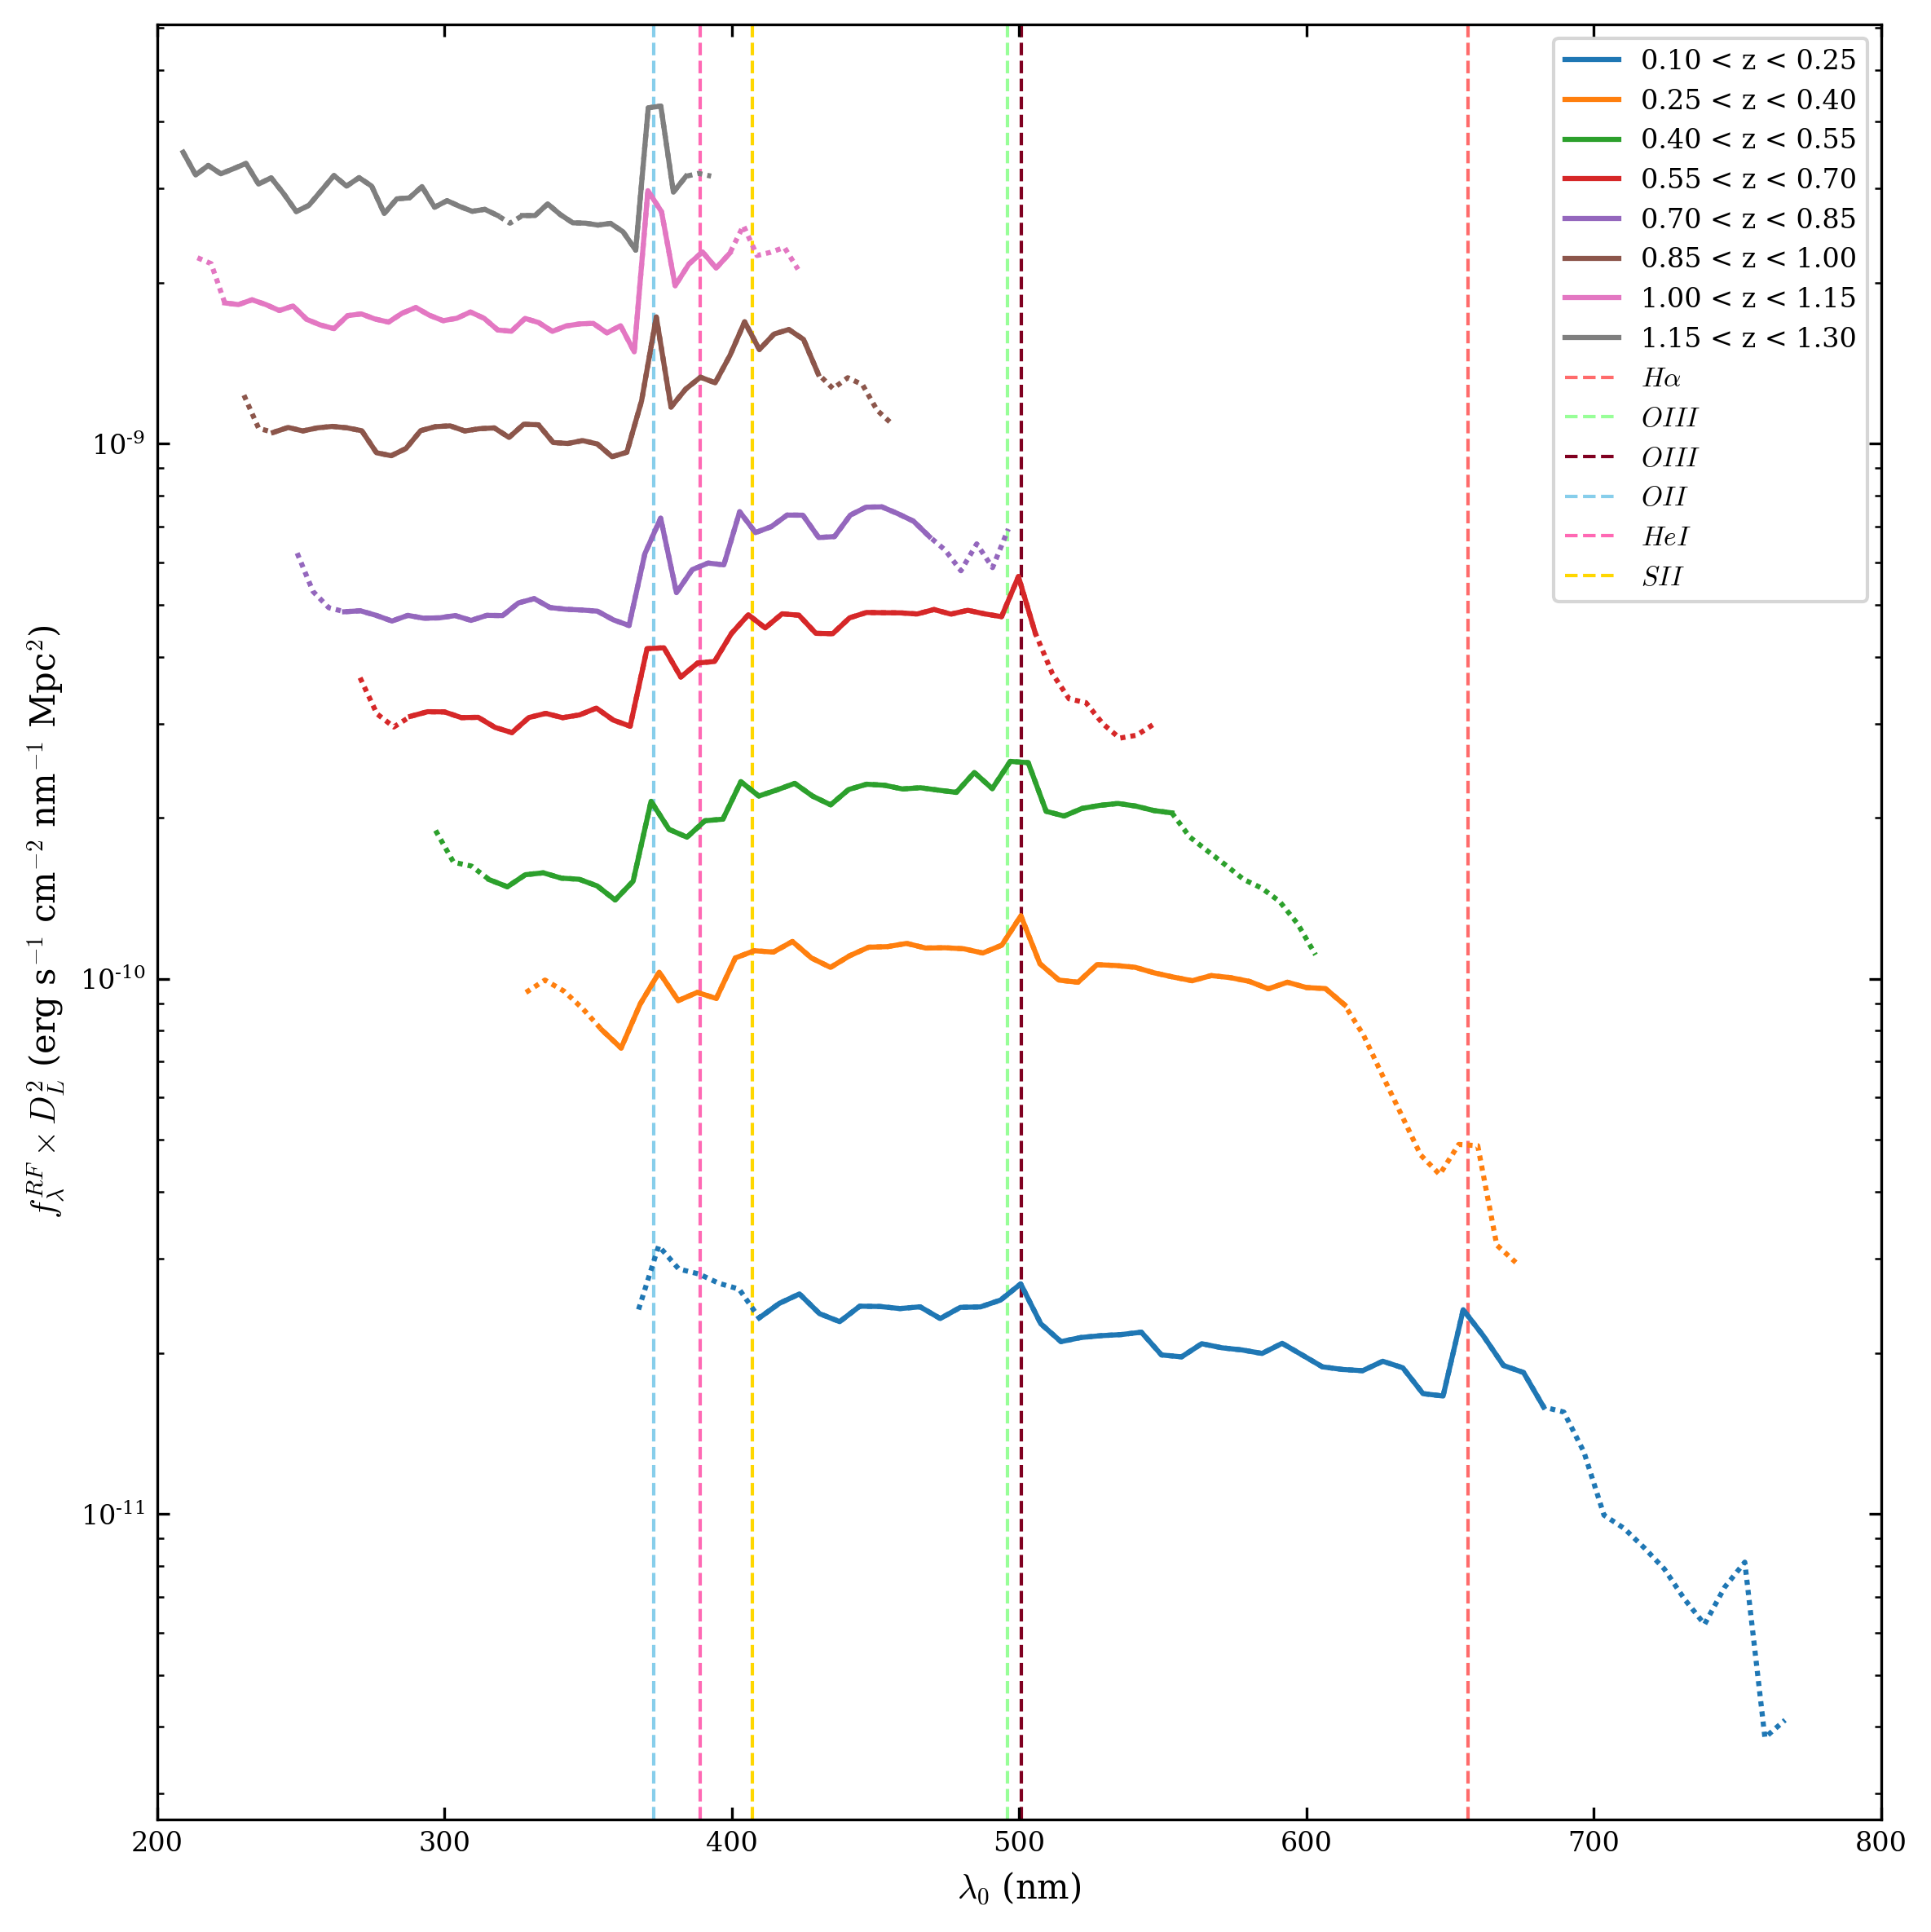

In [8]:


################################# PLOT 2 #################################
fig = plt.figure(figsize=(8,8),dpi=300)

bins = []
bin_range = [0.1,1.2]
bin_increment = 0.15
# temp_bins = np.arange(bin_range[0],bin_range[1]+bin_increment,bin_increment)
# for ind,i in enumerate(temp_bins[:-1]):
#     bins.append([temp_bins[ind],temp_bins[ind+1]]) 

bins = np.arange(bin_range[0],bin_range[1]+bin_increment, bin_increment)

max_factor = 7.25
# factor = 1/max_factor*latex_textwidth/72
# fig = plt.figure(figsize=(7.5*factor,max_factor*factor),dpi=300)

band_obsframe = data_sample.loc[:,'band0':'band39'].values/(data_sample['zb'].values[:,None]+1)

FWHM = 13 # nm
c = 299792458e9 # nm s^-1
cgs_factor = 10**(-(26+48.6)/2.5)
# defining FWHM of filter, PAUS flux -> cgs unit conversion factor, speed of light

increments = np.linspace(90,150,len(bins))
bandwidtharray = np.linspace(7,4,len(bins))

all_means = []


for ind,z_bin in enumerate(bins[:-1]):

    truth_table = (z_photos >= bins[ind]) & (z_photos <= bins[ind+1])
    n_objects = truth_table.sum()
    # selecting data based on redshift bins
    
    lamb_sample = band_obsframe[truth_table].flatten()
    flux_sample = data_sample.loc[truth_table,'band0_flux':'band39_flux'].values.flatten()
    # selecting obs. frame wavelengths and fluxes
    
    lum_dist_sample = luminosity_distances[truth_table].flatten()
    z_samp = np.repeat(z_photos[truth_table],40)
    band_width = bandwidtharray[ind]

    band_bins = np.arange(np.nanmin(lamb_sample),np.nanmax(lamb_sample)+band_width,band_width)

    
    N_objects = band_obsframe[truth_table].shape[0]
    
    digitized = np.digitize(lamb_sample,band_bins)
        
    binned_means = [np.nanmedian(flux_sample[digitized == i]*(1+z_samp[digitized == i])*cgs_factor*c/(lamb_sample[digitized==i])**2 * lum_dist_sample[digitized == i]**2) for i in range(1,len(band_bins))]
    
    all_means.append(binned_means) #flux(in AB mags)/band wl
#     plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
#              label="{:.02f} < z < {:.02f}".format(bins[ind],bins[ind+1]),zorder=10,\
#              linewidth=1.5,linestyle='--',dashes=(1,1)) #flux(in AB mags)/500 band wl

    binobject_count = np.bincount(digitized)
    eighty_percent_mask = binobject_count/n_objects > 0.75
    eighty_percent_mask = eighty_percent_mask[1:-1]    
    
    all_means.append(binned_means) #flux(in AB mags)/band wl
    
    
    line = plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means),\
             zorder=10,linewidth=1.5,linestyle='--', dashes = (1,1)) #flux(in AB mags)/500 band wl
    # plot median of redshift bin of all wl bins as dashed line
    
    plottingbins = (band_bins[1:]+band_bins[:-1])/2
    masked_data_x = np.ma.masked_where(~eighty_percent_mask,plottingbins)
    masked_data_y = np.ma.masked_where(~eighty_percent_mask,binned_means)
    plt.plot(masked_data_x,masked_data_y,\
             label="{:.02f} < z < {:.02f}".format(bins[ind],bins[ind+1]),\
             zorder=10,linewidth=1.5,linestyle='-', color=line[0].get_color())
    
    

emis_lines = [[656.28,r'$H\alpha$'],[496,r'$OIII$'],[500.8,r'$OIII$'],[372.8,r"$OII$"],[388.9,r'$HeI$'],[407.2,r'$SII$']]

for i,line in enumerate(emis_lines):
#     random_ints = np.random.randint(256,size=3)
# color = #{}{}{}'.format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2))
    plt.axvline(line[0],label=line[1],color=colours[i],linestyle='--',zorder=1)

plt.xlabel(r'$\lambda_0$ (nm)')
plt.ylabel(r'$f^{RF}_{\lambda} \times D_L^2$ (erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$ Mpc$^2$)')
plt.legend()

# ax1.tick_params(labelbottom=False)

plt.yscale('log')
# plt.ylim([0,2.5e6])
plt.xlim([200,800])
fixed_aspect_ratio(1)
plt.tight_layout()
# custom_SAVEFIG(filetag='SED_LD')

plt.show()

# Galaxy spectra

In [9]:
c = 299792458e9 # nm s^-1

def PAU_to_cgs(f,wl):
    cgs_nu = 10**(-(26+48.6)/2.5) * f
    # convert to cgs [erg s^-1 cm^-2 Hz^-1 ]
    cgs_lam = cgs_nu * c / wl**2
    # convert from Hz^-1 to nm^-1
    
    return cgs_lam

In [10]:
ref_ids = np.array([1790,4783,1971,2670])


In [11]:
sample_gals = data.loc[data['ref_id'].isin(ref_ids)].sort_values('zb')
restframe_wls = sample_gals.loc[:,'band0':'band39'].values / (sample_gals['zb'].values[:,None] + 1)
# calculate restframe wls

fluxs = sample_gals.loc[:,'band0_flux':'band39_flux']
fluxs_cgs = PAU_to_cgs(fluxs,restframe_wls)
# calculate cgs fluxes

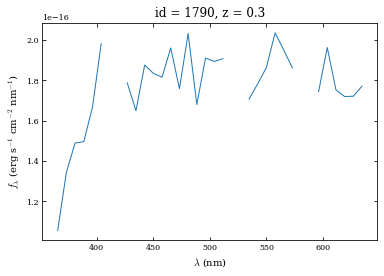

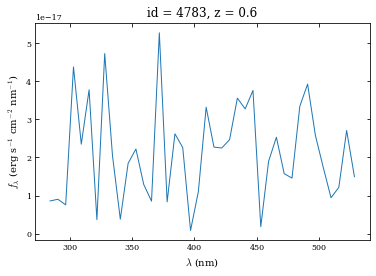

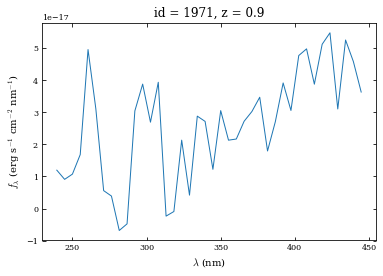

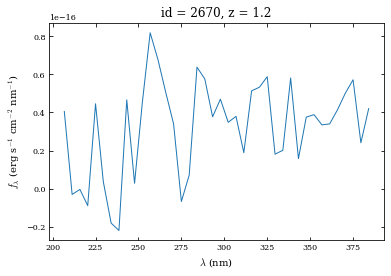

In [12]:
# Plotting

for ind,val in enumerate(ref_ids):
    plt.figure()
    plt.plot(restframe_wls[ind],fluxs_cgs.iloc[ind])
    plt.title("id = {}, z = {}".format(sample_gals.iloc[ind,0],sample_gals.iloc[ind,1]))
    plt.xlabel("$\lambda$ (nm)")
    plt.ylabel("$f_\lambda$ (erg s$^{-1}$ cm$^{-2}$ nm$^{-1}$)")
    plt.savefig("{}.pdf".format(sample_gals.iloc[ind,0]),format="pdf")
    plt.show()

In [13]:
print(cgs_factor)

1.4454397707459398e-30


In [14]:
def ub68(x):
    return np.percentile(x,50+34.1)

def lb68(x):
    return np.percentile(x,50-34.1)

In [15]:
r1, g1, b1 = 255, 235, 247
r1, g1, b1 = r1/255, g1/255, b1/255

cdict1 = {'red':   ((0.0, r1, r1),
                   (1.0, 0.75, 0.75)),

         'green': ((0.0, g1, g1),
                   (1.0, 0.04, 0.04)),

         'blue':  ((0.0, b1, b1),
                   (1.0, 0.4, 0.4)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1e-20, 1.0, 1.0),
                    (1.0, 1.0, 1.0))
        }

clear_purple = matplotlib.colors.LinearSegmentedColormap('ClearPurple', cdict1)
plt.register_cmap(cmap=clear_purple)

# kNN single reg performance

In [16]:
def compute_error_stats_singleReg(DFrame):
    z_annz = DFrame['F:ANNZ_best']
    z_paus = DFrame['F:Z']
    z_annz_errors = DFrame['F:ANNZ_best_err']

    error = z_annz - z_paus
    normed_error = error / (1+z_paus)

    outliers_idx = abs(normed_error) > 0.15
    out_perc = outliers_idx.sum()/outliers_idx.size *100

    return [normed_error.mean(),np.std(normed_error),(ub68(normed_error)-lb68(normed_error))/2,out_perc],[z_annz.values,z_annz_errors.values,z_paus.values]

In [17]:
knn_df = pd.read_csv('../../ML runs/PAUS_single4/ANNZ_singleReg_0000.csv')
error_stats, objs = compute_error_stats_singleReg(knn_df)

print(error_stats)

[0.006330059301829759, 0.10378652470958356, 0.07016474418525007, 8.603762272352544]


/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

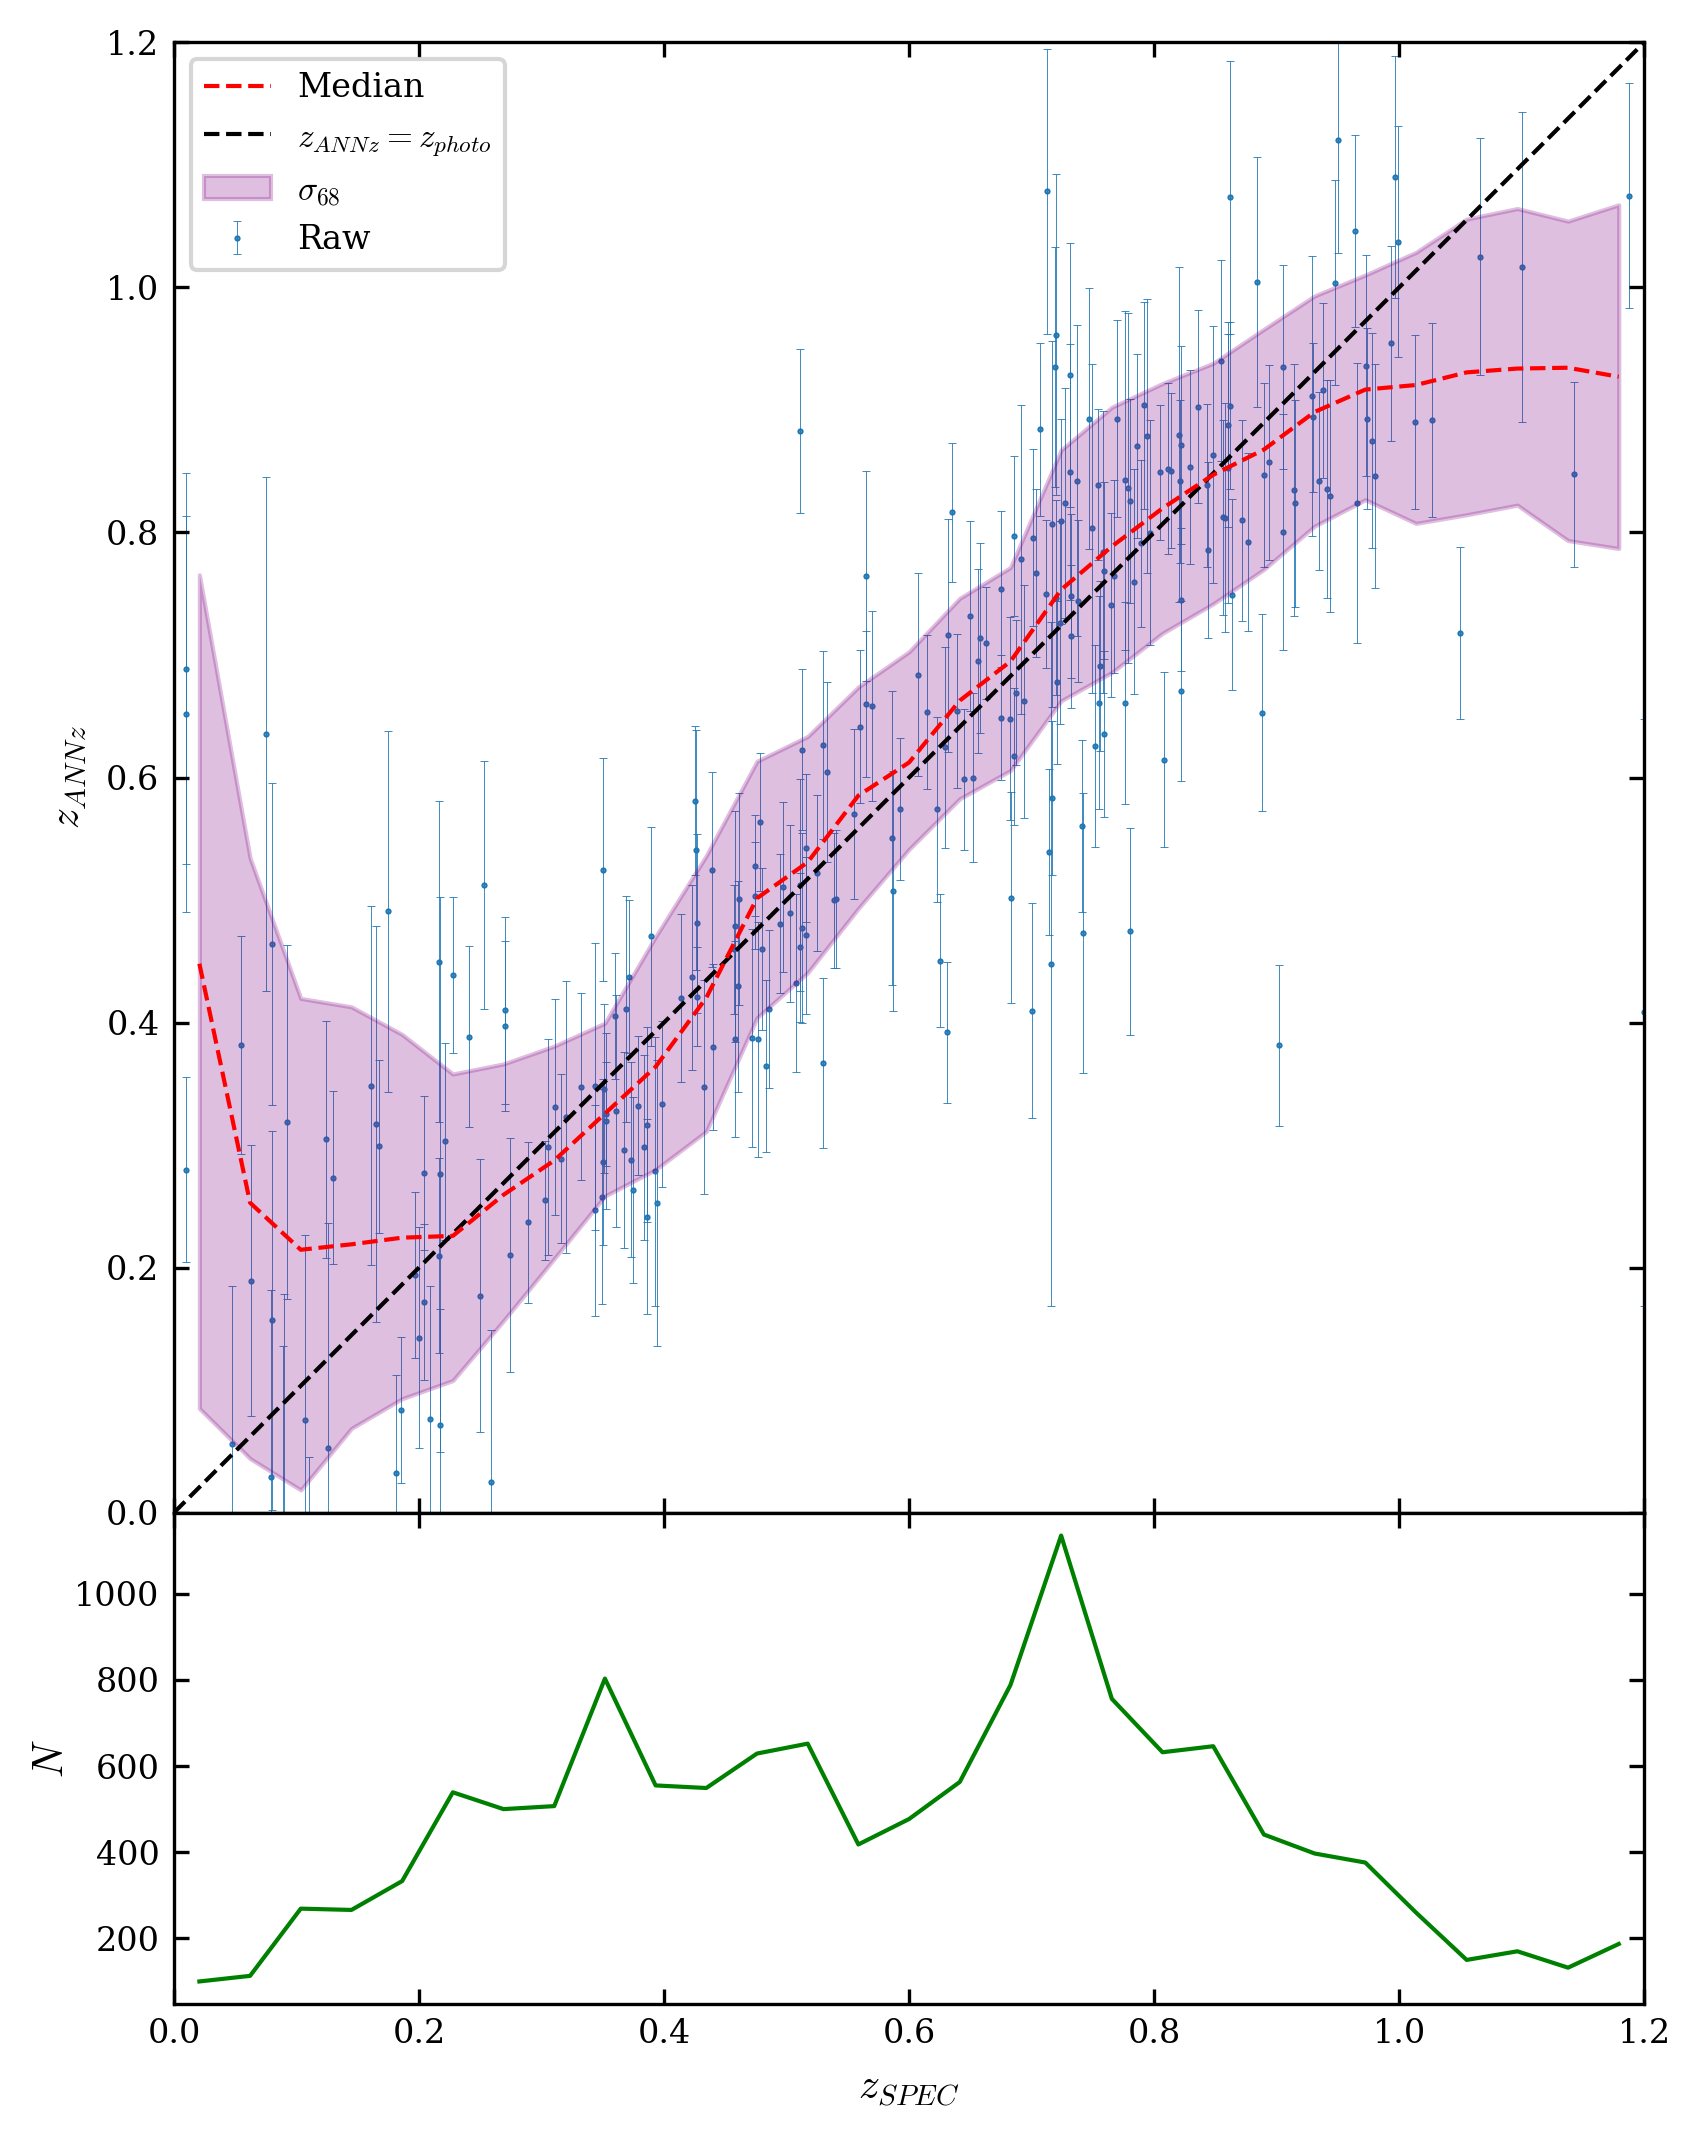

In [18]:
z_annz, z_annz_errors, z_paus = objs

N_points = 250
indices = np.random.choice(z_paus.size,N_points,replace=False)

min_bin, max_bin, N_bin = 0.0,1.2,30
bins = np.linspace(min_bin, max_bin, N_bin)
meds,edge,counts = scipy.stats.binned_statistic(z_paus,z_annz,'median',bins=bins)
lbs = scipy.stats.binned_statistic(z_paus,z_annz,lb68,bins)[0]
ubs = scipy.stats.binned_statistic(z_paus,z_annz,ub68,bins)[0]


factor = latex_textwidth/72#*0.5
# fig = plt.figure(figsize=(factor*1.2,factor),dpi=300)
fig, (ax1,ax2) = plt.subplots(2,1,gridspec_kw = {'height_ratios':[3, 1]},figsize=(1*factor,1.37*factor),dpi=300,sharex=True)

ax1.errorbar(z_paus[indices],z_annz[indices],yerr=z_annz_errors[indices]\
             ,fmt='o',ms=0.5,linewidth=0.2,capsize=1,capthick=0.2,label='Raw'.format(N_points),zorder=1)
ax1.plot((bins[:-1]+bins[1:])/2,meds,'r--',label='Median',zorder=5,linewidth=1)
ax1.plot([0,1.2],[0,1.2],'k--',label=r'$z_{ANNz}=z_{photo}$',zorder=4,linewidth=1)
ax1.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
ax2.set_xlabel(r'$z_{SPEC}$')
ax1.set_ylabel(r'$z_{ANNz}$')
ax1.legend(fontsize=8)
ax1.set_xlim(0.0,1.2)
ax1.set_ylim(0.0,1.2)
ax1.set_aspect('equal')

# ax2 = plt.subplot(212)
unique, counted = np.unique(counts, return_counts=True)
# print(unique,'\n',counted)
# ax2.plot((bins[:-1]+bins[1:])/2,counted/(max_bin-min_bin)*N_bin,'g-',zorder=5,linewidth=1)
# ax2.set_ylabel('$n$') #object density
ax2.plot((bins[:-1]+bins[1:])/2,counted,'g-',zorder=5,linewidth=1)
ax2.set_ylabel('$N$')
ax2.yaxis.labelpad=0.5


fig.subplots_adjust(hspace=0)
# custom_SAVEFIG('ML')

plt.show()

# MLM run comparison

In [30]:
MLM_data_list = []
read_order = [15,16,6,7,8,9,17,11]#,12,13,14]
for i in read_order:
    MLM_data_list.append(pd.read_csv('../../ML runs/SPEC_advanced{}/ANNZ_randomReg_0000.csv'.format(i),header=0))


In [31]:
# MLM_data_list

In [32]:
def compute_error_stats(DFrame):
    z_annz = DFrame['F:ANNZ_best']
    z_paus = DFrame['F:zspec']
    z_annz_errors = DFrame['F:ANNZ_best_err']

    error = z_annz - z_paus
    normed_error = error / (1+z_paus)

    outliers_idx = abs(normed_error) > 0.15
    out_perc = outliers_idx.sum()/outliers_idx.size *100

    return [normed_error.mean(),np.std(normed_error),(ub68(normed_error)-lb68(normed_error))/2,out_perc],[z_annz.values,z_annz_errors.values,z_paus.values]

In [33]:
stats = []
errors_obj = []
i = 6
for frame in MLM_data_list:
    tmp_stats = compute_error_stats(frame)
    stats.append(tmp_stats[0])
    errors_obj.append(np.array(tmp_stats[1]))
    i += 1

In [34]:
nMLM = [5,10,20,40,60,80,100,125]
results = pd.DataFrame(stats,index=nMLM,columns=["mean error","st. dev","68th percentile","percentage outliers"])
results

,mean error,st. dev,68th percentile,percentage outliers
5,0.007363,0.077037,0.051205,5.017921
10,0.007901,0.077645,0.051192,5.107527
20,0.007206,0.077259,0.049829,5.152330
40,0.007790,0.078110,0.051472,5.465950
60,0.007427,0.076933,0.050683,4.928315
80,0.007730,0.077306,0.050734,5.421147
100,0.007005,0.081800,0.050320,5.869176
125,0.006749,0.081741,0.050263,5.824373


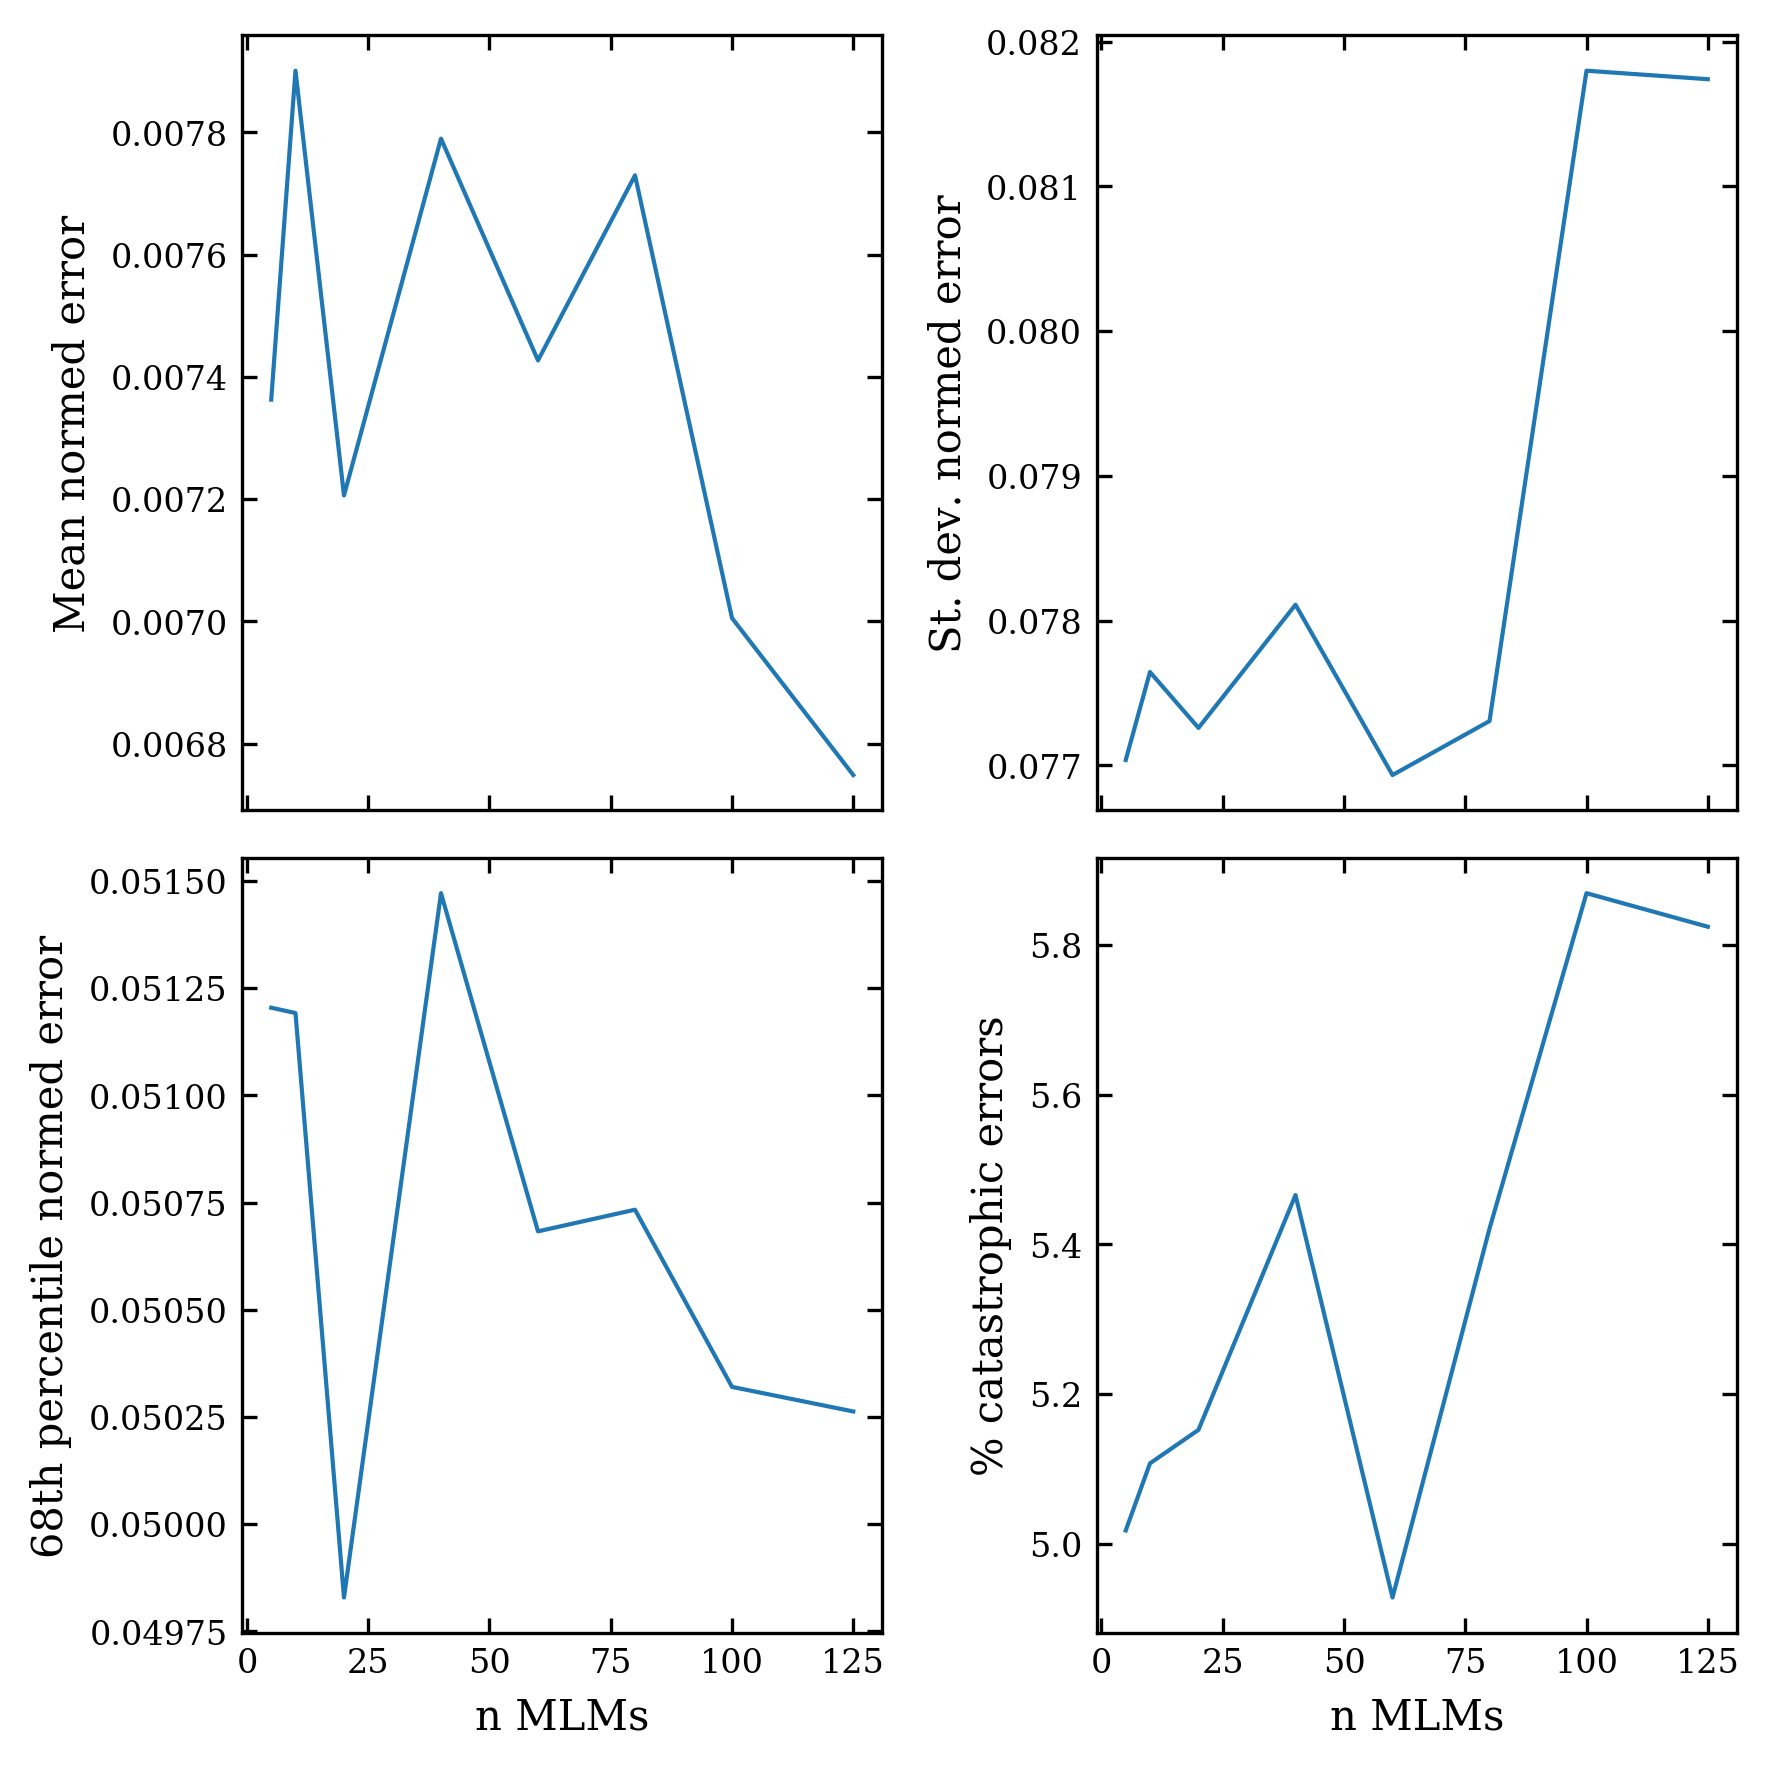

In [35]:
# plt.figure()
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex=True,figsize=(6,6),dpi=300)

ax1.plot(results.index.values,results.iloc[:,0])
ax1.set_ylabel("Mean normed error")

ax2.plot(results.index.values,results.iloc[:,1])
ax2.set_ylabel("St. dev. normed error")

ax3.plot(results.index.values,results.iloc[:,2])
ax3.set_xlabel("n MLMs")
ax3.set_ylabel("68th percentile normed error")

ax4.plot(results.index.values,results.iloc[:,3])
ax4.set_xlabel("n MLMs")
ax4.set_ylabel("% catastrophic errors")

plt.tight_layout()

plt.subplot

plt.show()

In [27]:
errors_all_MLMs = np.array(errors_obj)

In [28]:
errors_all_MLMs[0]

array([[0.87203658, 0.13634258, 0.64121962, ..., 0.57774389, 0.4043116 ,
        0.50519353],
       [0.049373  , 0.02440612, 0.04611095, ..., 0.03873475, 0.0519318 ,
        0.0222261 ],
       [0.87239999, 0.1867    , 0.53839999, ..., 0.44569999, 0.31029999,
        0.41859999]])

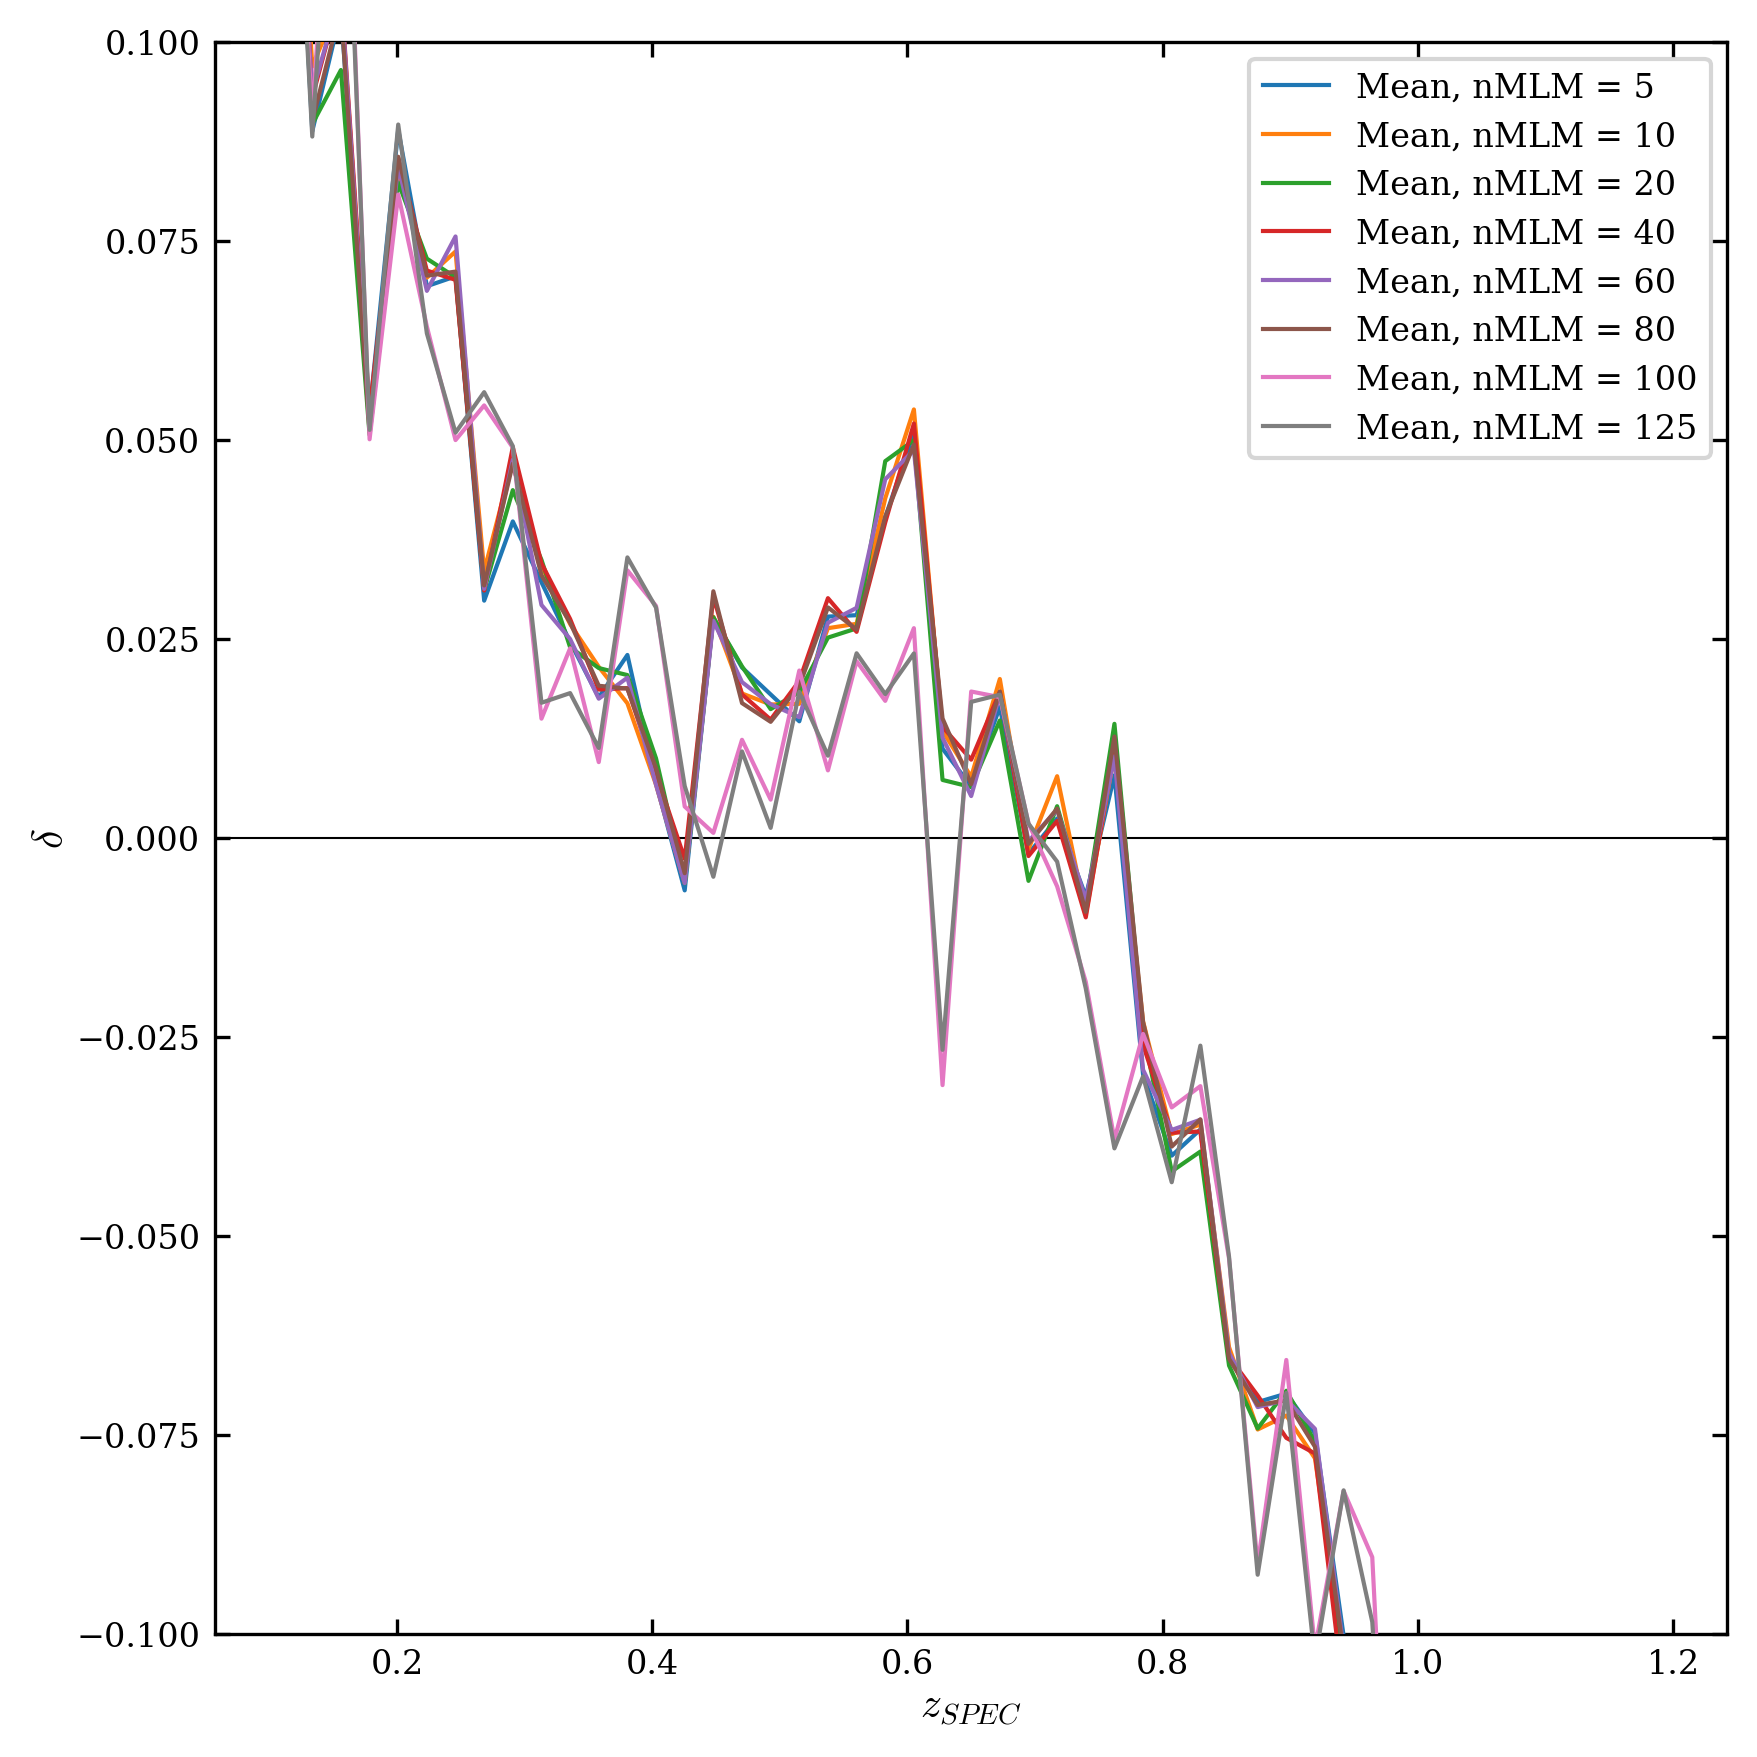

In [39]:


bins = np.linspace(0.1,1.2,50)

binned_means = []


for i in range(errors_all_MLMs.shape[0]): binned_means.append(scipy.stats.binned_statistic(errors_all_MLMs[i,2,:],errors_all_MLMs[i,0,:]-errors_all_MLMs[i,2,:],'mean',bins=bins)[0])

# lbs, edge, counts = scipy.stats.binned_statistic(z_paus,error,lb68,bins=bins)
# ubs, edge, counts = scipy.stats.binned_statistic(z_paus,error,ub68,bins=bins)

factor = latex_textwidth/72*0.5
plt.figure(figsize=(6,6),dpi=300)

# pixs = 600
# bounds = [0,0.9,1e6]
# norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)

# plt.fill_between((bins[1:]+bins[:-1])/2,lbs,ubs,alpha=0.25,zorder=3,label=r'$\sigma_{68}$',color='purple')
# hist = plt.hist2d(z_paus,error,[pixs,pixs],norm=norm,cmap='ClearPurple',zorder=2)
# norm=matplotlib.colors.LogNorm()

for i in range(errors_all_MLMs.shape[0]): plt.plot((bins[1:]+bins[:-1])/2,binned_means[i],zorder=10,label='Mean, nMLM = {}'.format(nMLM[i]))


plt.axhline(linewidth=0.5,zorder=3,color='black')
plt.ylabel('$\delta$')
plt.xlabel('$z_{SPEC}$')

# plt.scatter([-1],[-1],s=1,color='#c10968',label='Raw data')
# plt.xlim(0.1,0.7)
plt.ylim(-.1,0.1)

# plt.colorbar(hist[3])
plt.legend()
plt.tight_layout()
plt.gca().xaxis.labelpad = 1
plt.gca().yaxis.labelpad = 1
# custom_SAVEFIG('ML_ERROR')
plt.show()
